# Diagnóstico Inicial do Cancelamento - CCAAB

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_percentage(df, x, y, xlabel):   
    counts = df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    print(counts)
    g = sns.catplot(x=x, y='percent', hue=y, data=counts, kind='bar')
    
    g.set(xlabel = xlabel)
    
    new_title = 'Cancelamento'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ['Não', 'Sim']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.show()

df = pd.read_csv('/home/ramon/extrator/survival/evasao-100.csv')

In [2]:
def permutation_test(events, obs_diff, n1):
    n = len(events)
    n2 = n-n1
    idxs = np.arange(0, n)



    values = []
    for i in range(10000):
        foo = np.full(n, False)
        idx_a = np.random.choice(idxs, n1, replace=False)
        foo[idx_a] = True

        diff = np.abs(events[foo].mean() - events[~foo].mean())
        values.append(diff)

    return (np.mean(np.array(values) > obs_diff))

def proportion_test(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    counts = df[idx].groupby(col_name)['event'].mean().values
    obs_diff = np.abs(counts[0] - counts[1])
    n1 = df[idx][col_name].value_counts().values[0]
    events = df.loc[idx, 'event'].values
    
    return (permutation_test(events, obs_diff, n1))

from statsmodels.stats.proportion import proportions_ztest

def proportion_test2(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    count = df[idx].groupby(col_name)['event'].sum().values
    nobs = df[idx].groupby(col_name)['event'].count().values

    stat, pval = proportions_ztest(count, nobs)
    return pval

In [3]:
df.groupby('time')['event'].value_counts()

time  event
1     0        15393
      1         4059
2     0        13637
      1         1613
3     0        11820
      1         1100
4     0        10109
      1          800
5     0         8948
      1          652
6     0         7684
      1          425
7     0         6378
      1          307
8     0         5293
      1          203
9     0         4147
      1          170
10    0         3004
      1          120
11    0         1999
      1           92
12    0         1186
      1           65
13    0          768
      1           55
14    0          424
      1           27
15    0          246
      1           19
16    0          139
      1           13
17    0           78
      1            5
18    0           36
      1            3
19    0           17
      1            1
Name: event, dtype: int64

# Perfil dos Estudantes na Amostra

- 50% cancelaram
- 81% possuem cidade de origem diferente da cidade do campus
- 55% são do sexo feminino
- Idade média dos estudantes é 23
- Há 19452 números de matrículas

In [4]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

print(df[idx]['event'].value_counts(normalize=True))

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

print(df[idx]['sexo'].value_counts(normalize=True))

print(df[idx]['idade_ingresso'].mean())

print(df.matricula.nunique())

1    0.500154
0    0.499846
Name: event, dtype: float64
1    0.807835
0    0.192165
Name: is_outra_cidade, dtype: float64
0    0.545651
1    0.454349
Name: sexo, dtype: float64
23.494088011515526
19452


# Q1 Taxa de cancelamento é maior para estudantes cuja cidade de origem difere da cidade do campus?

- Não há diferença

1    0.807835
0    0.192165
Name: is_outra_cidade, dtype: float64
   is_outra_cidade  event    percent
0                0      0  50.321027
1                0      1  49.678973
2                1      1  50.095456
3                1      0  49.904544


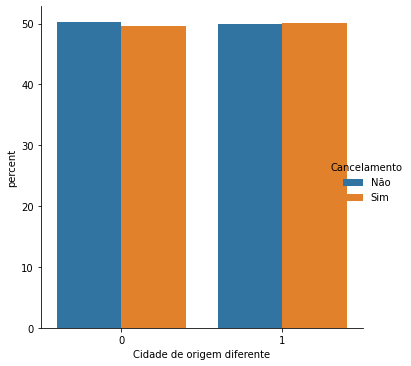

In [5]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_outra_cidade', 'event', 'Cidade de origem diferente')

In [6]:
#print('%.3f'%(proportion_test(df, 'is_outra_cidade')))
print(proportion_test2(df, 'is_outra_cidade'))

0.6471468840041792


# Q2 Taxa de cancelamento é maior para ingressantes no 1o semestre ou 2o semestre letivo? (Ex: taxa de cancelamento é maior para ingressantes em 2019.1 ou 2019.2?)

- Taxa é maior entre ingressantes no 1o semestre (52% vs 47%)
- A diferença é estatisticamente significativa

1    0.615207
2    0.384793
Name: semestreIngresso, dtype: float64
   semestreIngresso  event    percent
0                 1      1  51.616947
1                 1      0  48.383053
2                 2      0  52.545090
3                 2      1  47.454910


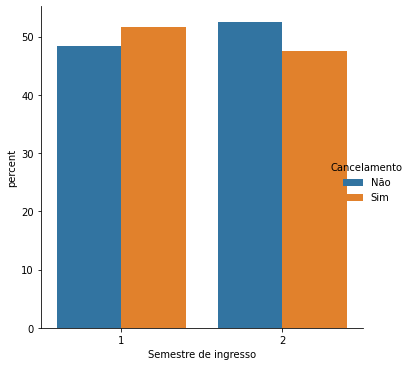

In [7]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['semestreIngresso'].value_counts(normalize=True))

plot_percentage(df[idx], 'semestreIngresso', 'event', 'Semestre de ingresso')

In [8]:
#print('%.3f'%(proportion_test(df, 'periodoingresso')))
print(proportion_test2(df, 'semestreIngresso'))

1.6174107310486155e-08


# Q4 Taxa taxa de cancelamento é maior para homens ou mulheres?

- Taxa é maior para homens (55% vs 46%)
- Diferença observada é significativa

0    0.545651
1    0.454349
Name: sexo, dtype: float64
   sexo  event    percent
0     0      0  54.126625
1     0      1  45.873375
2     1      1  54.989817
3     1      0  45.010183


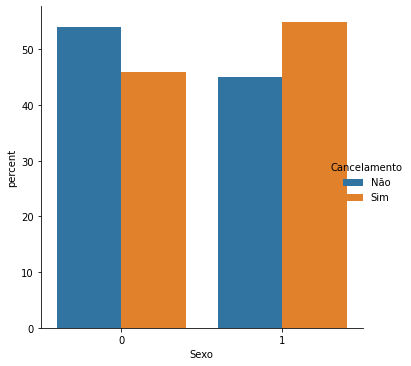

In [9]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['sexo'].value_counts(normalize=True))

plot_percentage(df[idx], 'sexo', 'event', 'Sexo')

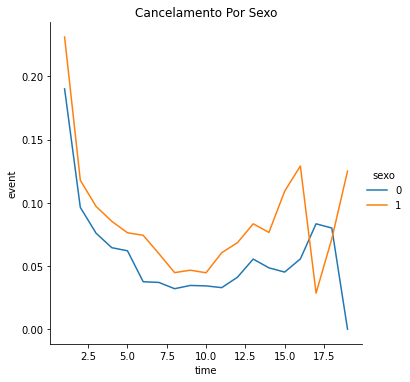

In [10]:
data = df.groupby(['time','sexo']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='sexo',  kind="line")    
ax.set(title='Cancelamento Por Sexo')    

In [11]:
#print('%.3f'%(proportion_test(df, 'sexo')))
print(proportion_test2(df, 'sexo'))

9.646882965241693e-37


# Q5 Taxa de cancelamento decresce com o tempo?

- A taxa tende a decrescer com o tempo

[Text(0.5, 1.0, 'Cancelamento Geral')]

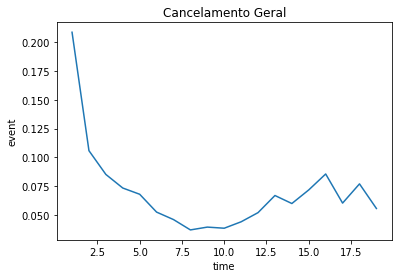

In [12]:
data = df.groupby('time').agg({'event':'mean'}).reset_index()

ax = sns.lineplot(x='time', y='event', data=data)    
ax.set(title='Cancelamento Geral')

# Q6 Taxa de cancelamento difere entre ingressantes por cota e ampla concorrência?

- Não há diferença

0    0.513418
1    0.486582
Name: is_cotista, dtype: float64
   is_cotista  event    percent
0           0      1  50.115150
1           0      0  49.884850
2           1      0  50.089805
3           1      1  49.910195


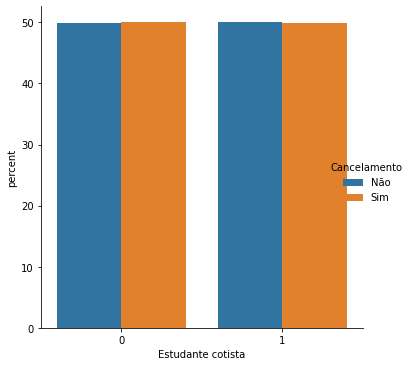

In [13]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_cotista'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_cotista', 'event', 'Estudante cotista')

In [14]:
#print('%.3f'%(proportion_test(df, 'is_cotista')))
print(proportion_test2(df, 'is_cotista'))

0.7750714289366902


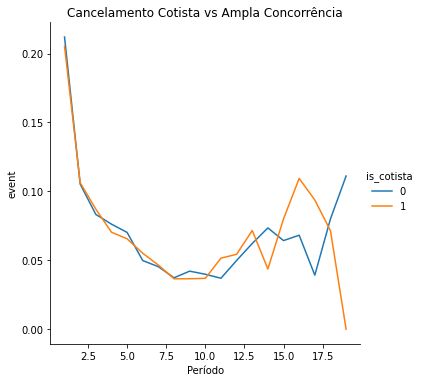

In [15]:
data = df.groupby(['time','is_cotista']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='is_cotista',  kind="line")    
ax.set(title='Cancelamento Cotista vs Ampla Concorrência', xlabel='Período')    

# Q.7 A idade de ingresso afeta a taxa de cancelamento?

- A idade de ingresso parece afetar a taxa

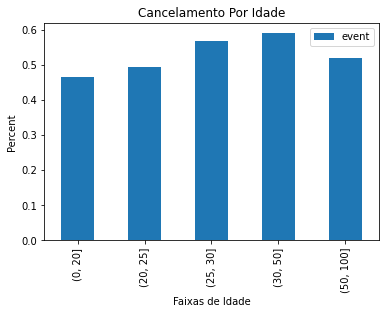

In [16]:
col = 'idade_cat'
df[col] = pd.cut(df.idade_ingresso, bins=[0,20,25,30,50,100])


ax = df[idx].groupby(col).agg({'event':'mean'}).plot.bar()
ax.set(ylabel="Percent")
ax.set(title='Cancelamento Por Idade', xlabel='Faixas de Idade')
plt.show()

# Turno afeta Cancelamento?

In [17]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('turno').agg({'event':'mean'})

,event
turno,
Matutino,0.339666
Matutino e Vespertino,0.531755
Noturno,0.472397
Vespertino,0.403509


# Grau afeta Cancelamento?

In [18]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('grau').agg({'event':'mean'})

,event
grau,
Bacharelado,0.499568
Licenciatura,0.495570
Tecnológico,0.520415


# Análise Bivariada

Idade Ingresso vs Turno


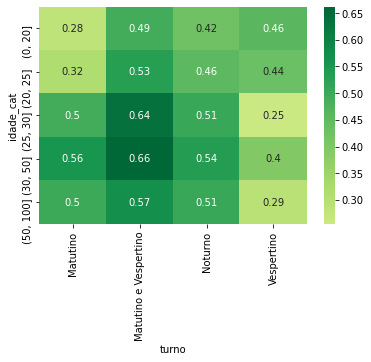

Idade Ingresso vs Grau do Curso


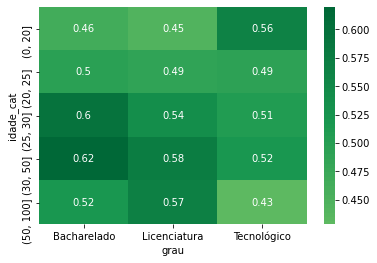

Idade Ingresso vs Sexo


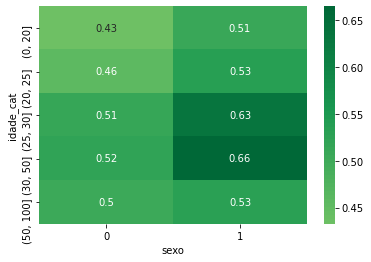

Idade Ingresso vs Cotista


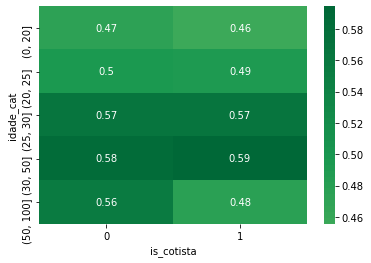

Idade Ingresso vs Migrante


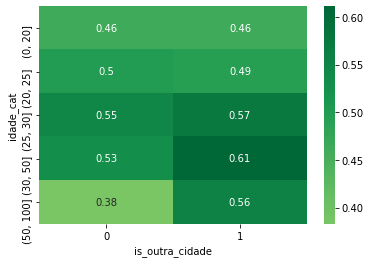

Idade Ingresso vs Período


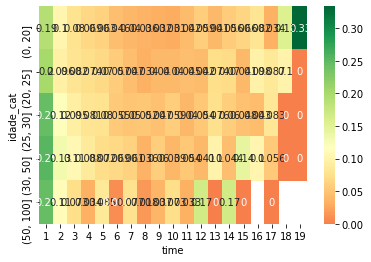

Turno vs Grau do Curso


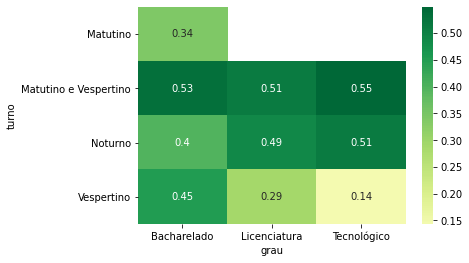

Turno vs Sexo


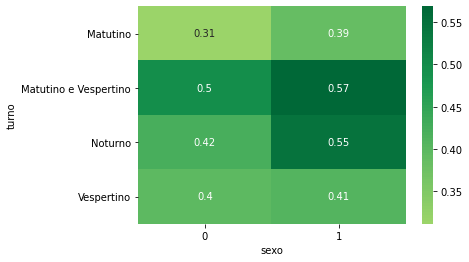

Turno vs Cotista


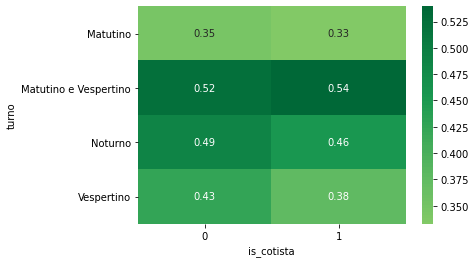

Turno vs Migrante


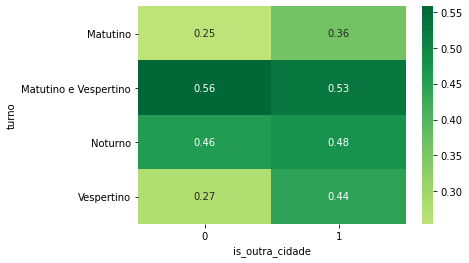

Turno vs Período


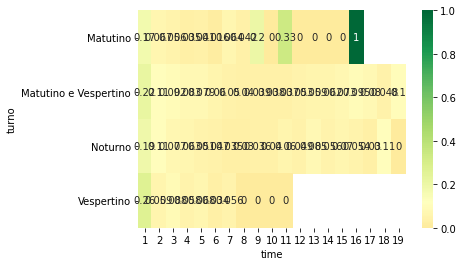

Grau do Curso vs Sexo


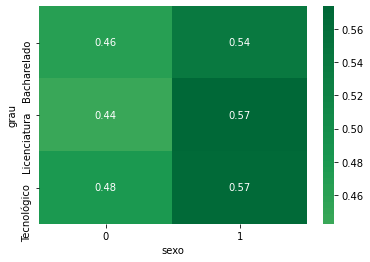

Grau do Curso vs Cotista


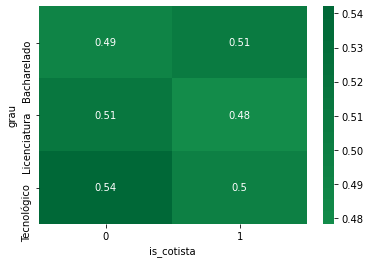

Grau do Curso vs Migrante


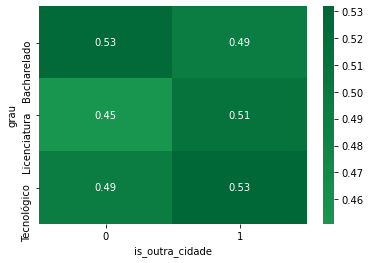

Grau do Curso vs Período


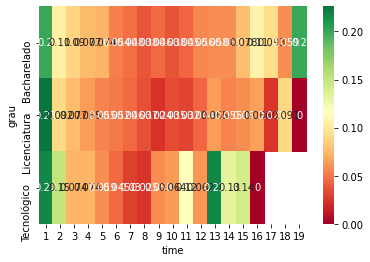

Sexo vs Cotista


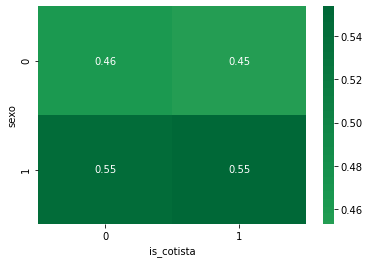

Sexo vs Migrante


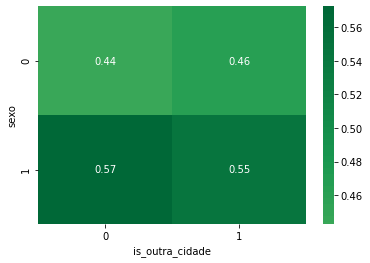

Sexo vs Período


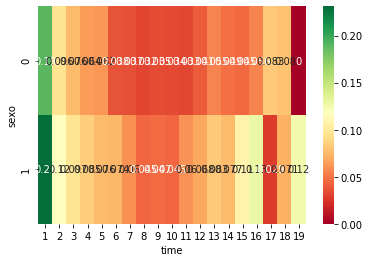

Cotista vs Migrante


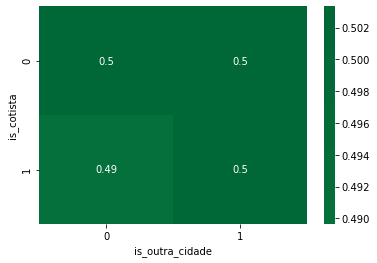

Cotista vs Período


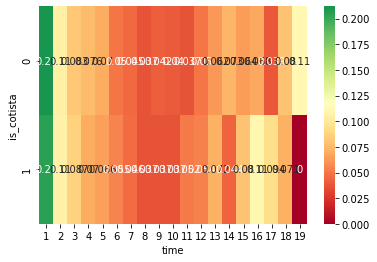

Migrante vs Período


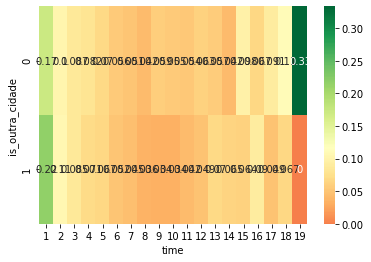

In [19]:
nomes = ['Idade Ingresso', 'Turno', 'Grau do Curso', 'Sexo', 'Cotista', 'Migrante', 'Período']
x = ['idade_cat', 'turno', 'grau', 'sexo', 'is_cotista',  'is_outra_cidade', 'time']

idx = df['time'] == df.groupby('matricula')['time'].transform('max')


for i in range(0, len(x)):
    for j in range(i+1, len(x)):
        print('%s vs %s'%(nomes[i], nomes[j]))
        if x[j] == 'time':
            result = pd.pivot_table(data=df, index=x[i], columns=x[j], values='event')
        else:
            result = pd.pivot_table(data=df[idx], index=x[i], columns=x[j], values='event')
        sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
        plt.show()